In [4]:
from config import *
from dataset import *
from model import *
from train import *
from visualize import *
import json

from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

import pandas as pd
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'

train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')
df_train, df_dev = train_test_split(train, test_size=0.05, random_state=42)
df_test = test

import numpy as np
import albumentations  # albumentations >= 1.0.0
from albumentations import pytorch as AT
test_transform = albumentations.Compose([
    AT.ToTensorV2()
])

cfg = {
    "BATCH_SIZE" : 16,
    "N_EPOCHS" : 1,
    "BACKBONE" : 'resnet50',
    "SUBMIT" : False,
    "FPN" : False,
    "CUT_AUG" : None,
    "COLOR_AUG" : None,
    "MASK_LOSS_TYPE" : "default",
    #ONLY useful with bce
    "LABEL_SMOOTHING" : 0.0,
    "TQDM_DISABLED" : True,
    "SCHEDULER": "MultiStep",
    "LEARNING_RATE": 0.001,
    "MILESTONE": [0.6, 0.9],
    "DISTANCE_THRESH_CLEAR": 2,
    "IMG_WIDTH": 1600,
    "MODEL_SCALE": 8,
    "FLIP_AUG": False,
    "SIDE_EXT": 4,
}

cfg["IMG_HEIGHT"] = (cfg["IMG_WIDTH"] // 16 * 5 + 32 // 2) // 32 * 32

print("cfg:\n", json.dumps(cfg, indent=4))

train_dataset = CarDataset(df_train, train_images_dir, cfg=cfg,training=True, transform=test_transform)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cfg:
 {
    "BATCH_SIZE": 16,
    "N_EPOCHS": 1,
    "BACKBONE": "resnet50",
    "SUBMIT": false,
    "FPN": false,
    "CUT_AUG": null,
    "COLOR_AUG": null,
    "MASK_LOSS_TYPE": "default",
    "LABEL_SMOOTHING": 0.0,
    "TQDM_DISABLED": true,
    "SCHEDULER": "MultiStep",
    "LEARNING_RATE": 0.001,
    "MILESTONE": [
        0.6,
        0.9
    ],
    "DISTANCE_THRESH_CLEAR": 2,
    "IMG_WIDTH": 1600,
    "MODEL_SCALE": 8,
    "FLIP_AUG": false,
    "SIDE_EXT": 4,
    "IMG_HEIGHT": 512
}


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_model = CenterNet(8, backbone="resnet18").cuda()

load size: 60/60


In [6]:
# model test
# resetn18:     40519920
# resnet18 fpn: 53509872
# resnet50:     55075568
# resnet50 fpn: 68065520
# resnet1010:   74067696
# resnet101 fpn:87057648

img, mask, regr = train_dataset[0]
img = torch.tensor(img).to(device)
mask = torch.tensor(mask).to(device)
regr = torch.tensor(regr).to(device)
# (3, 320, 1024)
print("img.shape", img.shape)
# (40, 128)
print("mask: ", mask.shape)
# (7, 40, 128)
print("regr: ", regr.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
f8, f16, f32 = test_model.base_model(torch.tensor(img[None]).to(device))
# torch.Size([1, 128, 40, 128])
print("f8.shape", f8.shape)
# torch.Size([1, 256, 20, 64])
print("f16.shape", f16.shape)
# torch.Size([1, 512, 10, 32])
print("f32.shape", f32.shape)

test_output = test_model(torch.tensor(img[None]).to(device), verbose=True)
print(f"test_output shape: {test_output.shape}")

loss, mask_loss, regr_loss = criterion(test_output, mask[None], regr[None])
print(f"loss: {loss.data}")
print(f"mask_loss: {mask_loss.data}")
print(f"regr_loss: {regr_loss.data}")

no_smoothing_loss = criterion(test_output, mask[None], regr[None], mask_loss_type="focal")
print(f"nosmoothing loss: {no_smoothing_loss[0]}")
print(f"nosmoothing mask_loss: {no_smoothing_loss[1]}")
print(f"nosmoothing regr_loss: {no_smoothing_loss[2]}")

print(f"count parameters: {count_parameters(test_model)}")

/tmp/ipykernel_4093174/1063874101.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img).to(device)
/tmp/ipykernel_4093174/1063874101.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f8, f16, f32 = test_model.base_model(torch.tensor(img[None]).to(device))


img.shape torch.Size([3, 512, 1600])
mask:  torch.Size([64, 200])
regr:  torch.Size([7, 64, 200])
device: cuda


/home/jichuanh/miniconda3/envs/open-mmlab/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400431970/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
/tmp/ipykernel_4093174/1063874101.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output = test_model(torch.tensor(img[None]).to(device), verbose=True)


f8.shape torch.Size([1, 128, 64, 200])
f16.shape torch.Size([1, 256, 32, 100])
f32.shape torch.Size([1, 512, 16, 50])
x: torch.Size([1, 3, 512, 1600])
mesh1: torch.Size([1, 2, 512, 1600])
x0: torch.Size([1, 5, 512, 1600])
x1: torch.Size([1, 64, 256, 800])
x2: torch.Size([1, 128, 128, 400])
x3: torch.Size([1, 512, 64, 200])
x4: torch.Size([1, 1024, 32, 100])

feats8: torch.Size([1, 128, 64, 200])
feats16: torch.Size([1, 256, 32, 100])
feats32: torch.Size([1, 512, 16, 50])
lat8: torch.Size([1, 256, 64, 200])
lat16: torch.Size([1, 256, 32, 100])
lat32: torch.Size([1, 256, 16, 50])

mesh2: torch.Size([1, 2, 16, 50])
feats: torch.Size([1, 258, 16, 50])
up1: torch.Size([1, 512, 32, 100])
up2: torch.Size([1, 256, 64, 200])
x: torch.Size([1, 8, 64, 200])

test_output shape: torch.Size([1, 8, 64, 200])
loss: 8524.6650390625
mask_loss: 8520.771484375
regr_loss: 3.8936848640441895
nosmoothing loss: 4.018208026885986
nosmoothing mask_loss: 0.1245233416557312
nosmoothing regr_loss: 3.89368486404418

scheduler: 
	milestones: Counter({25: 1, 40: 1})
	gamma: 0.1
	base_lrs: [0.001]
	last_epoch: 0
	verbose: False
	_step_count: 1
	_get_lr_called_within_step: False
	_last_lr: [0.001]


(0.0, 51.45)

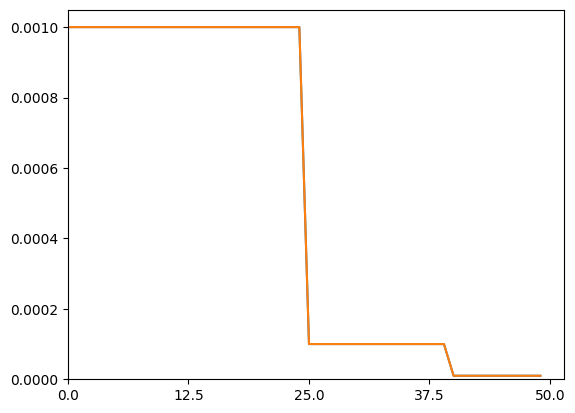

In [7]:
# test learning rate
import torch.optim as optim
from torch.optim import lr_scheduler
from functools import partial
import matplotlib.pyplot as plt

N_EPOCHS = 50

dummy_model = torch.nn.Linear(2, 1)
dummy_optimizer = torch.optim.SGD(dummy_model.parameters(), lr=0.001)
scheduler = partial(lr_scheduler.MultiStepLR, milestones=(np.array([0.5, 0.8])*N_EPOCHS).astype(int), gamma=0.1)

dummy_scheduler = scheduler(dummy_optimizer)

print("scheduler: ")
for k, v in dummy_scheduler.state_dict().items():
    print(f"\t{k}: {v}")

lrs = []
for i in range(N_EPOCHS):
    dummy_optimizer.step()
    lrs.append(dummy_optimizer.param_groups[0]["lr"])
#     print("Factor = ",i," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    dummy_scheduler.step()

plt.plot(lrs)

dim = 5
xticks = (N_EPOCHS - 1) // dim + 1
plt.plot(lrs)
plt.xticks(np.linspace(0, xticks*dim, dim))
plt.ylim(bottom=0)
plt.xlim(left=0)

In [8]:
import torch 

def loss_fn(y_true, y_pred):
    pred_mask = torch.sigmoid(y_pred)
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = y_true * torch.log(pred_mask + 1e-12) + (1 - y_true) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()

    return mask_loss

def modified_focal_loss(pred, gt):
    """
    focal loss copied from CenterNet, modified version focal loss
    change log: numeric stable version implementation
    """
    pos_inds = gt.eq(1).float()
    neg_inds = gt.lt(1).float()

    neg_weights = torch.pow(1 - gt, 4)
    # clamp min value is set to 1e-12 to maintain the numerical stability
    pred = torch.clamp(pred, 1e-12)

    pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0:
        loss = -neg_loss
    else:
        loss = -(pos_loss + neg_loss) / num_pos
    return loss

CELoss_smooth = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
CELoss = torch.nn.CrossEntropyLoss()

sample1 = torch.tensor([0.1, 0.5, 0.3])
sample2 = torch.tensor([0, 1, 0], dtype=torch.float)

print(f"loss default: {loss_fn(sample1, sample2)}")
print(f"loss centernet modified focal: {modified_focal_loss(sample1, sample2)}")
print(f"loss cross entropy smooth: {CELoss_smooth(sample1, sample2)}")
print(f"loss cross entropy: {CELoss(sample1, sample2)}")



loss default: 0.733185350894928
loss centernet modified focal: 0.20644114911556244
loss cross entropy smooth: 0.9319014549255371
loss cross entropy: 0.9119014739990234


In [9]:
pred_regr = torch.rand(1, 7, 40, 128)
regr = torch.rand(1, 7, 40, 128)
mask = torch.rand(1, 1, 40, 128) > 0.5
print(mask.shape)
tmp = pred_regr - regr
tmp = torch.abs(pred_regr - regr).sum(1)
print(tmp.shape)
regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
print(regr_loss)
print(regr_loss.shape)
regr_loss = regr_loss.mean(0)
print(regr_loss)

torch.Size([1, 1, 40, 128])
torch.Size([1, 40, 128])
tensor([[2.5162, 2.4763, 2.4015, 2.3872, 2.2498, 2.5186, 2.3654, 2.5270, 2.2230,
         2.4061, 2.4015, 2.4750, 2.5194, 2.1649, 2.5032, 2.2245, 2.2171, 2.2611,
         1.9597, 2.4348, 2.1685, 2.5287, 2.3625, 2.1866, 2.4060, 2.3288, 2.2396,
         2.3539, 2.5108, 2.4188, 2.2698, 2.2370, 2.1775, 2.2648, 2.3191, 2.5520,
         2.3010, 2.3038, 2.4669, 2.4387, 2.1789, 2.3468, 2.3648, 2.3428, 2.2729,
         2.3824, 2.5114, 2.4067, 2.3356, 2.5968, 2.3503, 2.4106, 2.3114, 2.1581,
         2.2687, 2.1420, 2.2273, 2.1535, 2.0245, 2.3004, 2.6557, 2.2673, 2.3653,
         2.2481, 2.6080, 2.2622, 2.4863, 2.5743, 2.1680, 2.2943, 2.5564, 2.1389,
         2.0712, 2.6396, 2.5110, 2.5010, 2.0640, 2.3085, 2.2693, 2.2422, 2.2469,
         2.3328, 2.3528, 2.2174, 2.3067, 2.3182, 2.4611, 2.1355, 2.6114, 2.4276,
         2.2905, 2.1262, 2.1952, 2.2451, 2.2497, 2.3185, 2.3479, 2.0290, 2.6329,
         2.2341, 2.3892, 2.1417, 2.2152, 2.2539, 2.4218,

fast mode img shape: (2710, 3384, 3)
preprocessed: (512, 1600, 3)
au img: torch.Size([3, 512, 1600])
[[0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44313726 0.44313726 0.44313726 0.44313726 0.44313726]
 [0.44313726 0.44313726 0.44313726 0.44313726 0.44313726]]
rau img: (512, 1600, 3)
[[0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44313726 0.44313726 0.44313726 0.44313726 0.44313726]
 [0.44313726 0.44313726 0.44313726 0.44313726 0.44313726]]
np img: (3, 512, 1600)
[[0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44705883 0.44705883 0.44705883 0.44705883 0.44705883]
 [0.44313726 0.44313726 0.44313726 0.44313726 0.44313726]
 [0.44313726 0.44313726 0.44313726 0.4

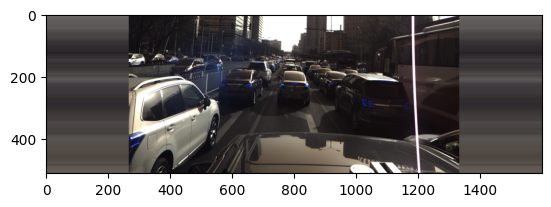

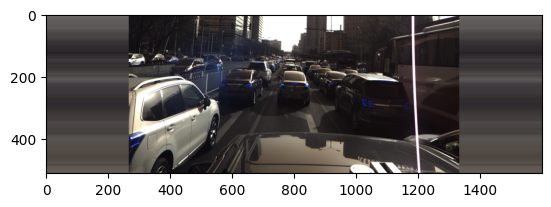

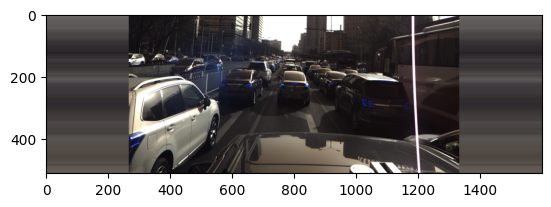

In [21]:
img = imread(train_images_dir.format(df_train['ImageId'].iloc[0]), True)
print(f"fast mode img shape: {img.shape}")
cu = ConfiguredUtils(cfg)

p_img = cu.preprocess_image(img)
print(f"preprocessed: {p_img.shape}")
plt.figure()
plt.imshow(p_img)

au_img = test_transform(image=p_img)["image"]
print(f"au img: {au_img.shape}")
print(au_img[0, 0:5, 0:5].numpy())
rau_img = np.rollaxis(au_img.numpy(), 0, 3)
print(f"rau img: {rau_img.shape}")
print(rau_img[0:5, 0:5, 0])
plt.figure()
plt.imshow(rau_img)

np_img = np.rollaxis(p_img, 2, 0)
print(f"np img: {np_img.shape}")
print(np_img[0, 0:5, 0:5])
nnp_img = np.rollaxis(np_img, 0, 3)
print(f"nnp img: {nnp_img.shape}")
print(nnp_img[0:5, 0:5, 0])
plt.figure()
plt.imshow(nnp_img)

print(np.array_equal(au_img.numpy(), np_img))
print(np.array_equal(rau_img, nnp_img))
